In [4]:
!pip install transformers torch nltk rouge-score scikit-learn pandas matplotlib seaborn bert-score sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving deepseek_finetuned_chomsky_responses.jsonl to deepseek_finetuned_chomsky_responses (1).jsonl
Saving deepseek_cag_output_responses.jsonl to deepseek_cag_output_responses (1).jsonl
Saving deepseek_basemodel_output.jsonl to deepseek_basemodel_output (1).jsonl
Fine-tuned file pairs: 100
CAG-Fused file pairs: 100
Base Model file pairs: 100


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

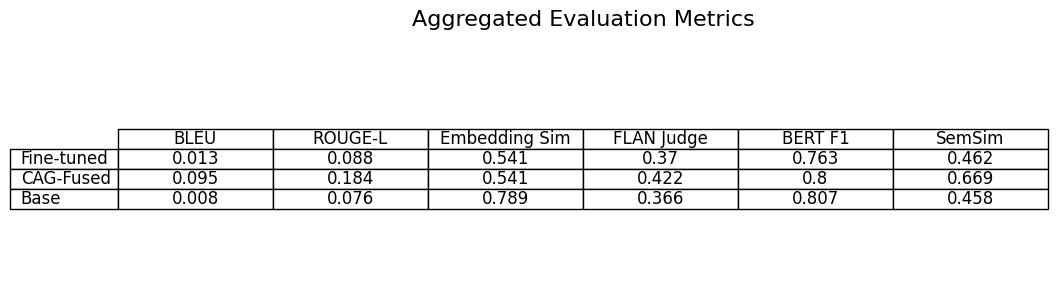

Aggregated Evaluation Metrics:
             BLEU  ROUGE-L  Embedding Sim  FLAN Judge  BERT F1  SemSim
Fine-tuned  0.013    0.088          0.541       0.370    0.763   0.462
CAG-Fused   0.095    0.184          0.541       0.422    0.800   0.669
Base        0.008    0.076          0.789       0.366    0.807   0.458


In [8]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nltk
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from bert_score import score as bert_score_func
from sentence_transformers import SentenceTransformer, util

# Download NLTK data if needed
nltk.download('punkt')

# ---------------------------- CONFIG ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FLAN_MODEL_NAME = "google/flan-t5-large"
STS_MODEL_NAME = "all-MiniLM-L6-v2"  # Sentence Transformer for semantic similarity

# ---------------------------- UPLOAD FILES ----------------------------
from google.colab import files
uploaded = files.upload()

def load_jsonl_file_from_upload(filename, uploaded_files):
    """
    Load a JSONL file from the uploaded dict or from local disk.
    """
    if filename in uploaded_files:
        file_bytes = uploaded_files[filename]
        text = file_bytes.decode('utf-8').splitlines()
        return [json.loads(line) for line in text if line.strip()]
    else:
        with open(filename, 'r') as f:
            return [json.loads(line) for line in f]

def load_all_data(uploaded_files):
    finetuned = load_jsonl_file_from_upload('deepseek_finetuned_chomsky_responses.jsonl', uploaded_files)
    cagfused  = load_jsonl_file_from_upload('deepseek_cag_output_responses.jsonl', uploaded_files)
    basemodel = load_jsonl_file_from_upload('deepseek_basemodel_output.jsonl', uploaded_files)
    return finetuned, cagfused, basemodel

# ---------------------------- PREPROCESSING ----------------------------
def preprocess_response(response):
    """
    Remove system prompts and return only the assistant's answer.
    Searches for "assistant" (case-insensitive) and returns subsequent text.
    """
    if isinstance(response, str):
        pattern = r"(?i)assistant\s*[:\n]+\s*(.+)$"
        match = re.search(pattern, response, re.DOTALL)
        if match:
            return match.group(1).strip()
    return response

def extract_pairs(data):
    """
    Extract dialogue pairs from a JSONL file.

    For Fine-tuned: uses "expected_response" and "generated_response".
    For Base Model: uses "expected" and "base_response".
    For CAG-Fused: if "expected" exists, uses it; otherwise uses "prompt" as reference, and "response" as candidate.
    """
    pairs = []
    for item in data:
        if "expected_response" in item and "generated_response" in item:
            ref = item["expected_response"]
            cand = preprocess_response(item["generated_response"])
            pairs.append((ref, cand))
        elif "expected" in item and "base_response" in item:
            ref = item["expected"]
            cand = preprocess_response(item["base_response"])
            pairs.append((ref, cand))
        elif "response" in item:
            if "expected" in item:
                ref = item["expected"]
            elif "prompt" in item:
                ref = item["prompt"]
            else:
                ref = ""
            cand = preprocess_response(item["response"])
            pairs.append((ref, cand))
    return pairs

# ---------------------------- METRIC FUNCTIONS ----------------------------
def compute_bleu(reference, candidate):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], candidate.split(), smoothing_function=smoothie)

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    score = scorer.score(reference, candidate)
    return {
        'rouge1': score['rouge1'].fmeasure,
        'rouge2': score['rouge2'].fmeasure,
        'rougeL': score['rougeL'].fmeasure
    }

def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def compute_cosine_sim(ref, cand, tokenizer, model):
    emb1 = get_bert_embedding(ref, tokenizer, model)
    emb2 = get_bert_embedding(cand, tokenizer, model)
    return cosine_similarity(emb1, emb2)[0][0]

def compute_bert_f1(reference, candidate):
    P, R, F1 = bert_score_func([candidate], [reference], lang="en", verbose=False)
    return F1.mean().item()

def compute_semantic_similarity(reference, candidate, sts_model):
    """
    Compute semantic similarity using sentence embeddings from a Sentence Transformer.
    """
    emb_ref = sts_model.encode(reference, convert_to_tensor=True)
    emb_cand = sts_model.encode(candidate, convert_to_tensor=True)
    return util.cos_sim(emb_ref, emb_cand).item()

# ---------------------------- FLAN-T5 LARGE JUDGE ----------------------------
def load_flan_judge():
    flan_tokenizer = AutoTokenizer.from_pretrained(FLAN_MODEL_NAME)
    flan_model = AutoModelForSeq2SeqLM.from_pretrained(FLAN_MODEL_NAME).to(DEVICE)
    return flan_tokenizer, flan_model

def flan_judge_score(ref, cand, tokenizer, model):
    prompt = (
        f"On a scale of 1 to 10, how well does the following answer match the reference?\n\n"
        f"Reference: {ref}\n\nAnswer: {cand}\n\nScore (only a number):"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=3)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    try:
        score = float(re.findall(r"\d+\.?\d*", decoded)[0])
        return score / 10  # Normalize score to range 0–1
    except:
        return 0.0

# ---------------------------- MAIN EVALUATION ----------------------------
def evaluate(uploaded_files):
    # Load each file from the uploader.
    ft, cg, bm = load_all_data(uploaded_files)
    ft_pairs = extract_pairs(ft)
    cg_pairs = extract_pairs(cg)
    bm_pairs = extract_pairs(bm)

    print(f"Fine-tuned file pairs: {len(ft_pairs)}")
    print(f"CAG-Fused file pairs: {len(cg_pairs)}")
    print(f"Base Model file pairs: {len(bm_pairs)}")

    # Load a BERT model for computing cosine similarity (as Embedding Similarity).
    bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    bert_model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

    # Load Sentence Transformer for semantic similarity.
    sts_model = SentenceTransformer(STS_MODEL_NAME)

    # Load Flan-T5 for judgment.
    flan_tokenizer, flan_model = load_flan_judge()

    models = {
        "Fine-tuned": ft_pairs,
        "CAG-Fused": cg_pairs,
        "Base": bm_pairs
    }

    results = {name: {"BLEU": [], "ROUGE-L": [], "Embed": [], "FLAN": [], "BERT F1": [], "SemSim": []}
               for name in models}

    for name, pairs in models.items():
        for ref, cand in pairs:
            if not ref.strip():
                continue
            bleu = compute_bleu(ref, cand)
            rougeL = compute_rouge(ref, cand)['rougeL']
            embed = compute_cosine_sim(ref, cand, bert_tokenizer, bert_model)
            flan = flan_judge_score(ref, cand, flan_tokenizer, flan_model)
            bert_f1 = compute_bert_f1(ref, cand)
            sem_sim = compute_semantic_similarity(ref, cand, sts_model)
            results[name]["BLEU"].append(bleu)
            results[name]["ROUGE-L"].append(rougeL)
            results[name]["Embed"].append(embed)
            results[name]["FLAN"].append(flan)
            results[name]["BERT F1"].append(bert_f1)
            results[name]["SemSim"].append(sem_sim)

    # Aggregate metrics: compute the average for each metric per model.
    agg_results = {}
    for name in models:
        agg_results[name] = {
            "BLEU": np.mean(results[name]["BLEU"]) if results[name]["BLEU"] else 0.0,
            "ROUGE-L": np.mean(results[name]["ROUGE-L"]) if results[name]["ROUGE-L"] else 0.0,
            "Embedding Sim": np.mean(results[name]["Embed"]) if results[name]["Embed"] else 0.0,
            "FLAN Judge": np.mean(results[name]["FLAN"]) if results[name]["FLAN"] else 0.0,
            "BERT F1": np.mean(results[name]["BERT F1"]) if results[name]["BERT F1"] else 0.0,
            "SemSim": np.mean(results[name]["SemSim"]) if results[name]["SemSim"] else 0.0
        }

    df = pd.DataFrame(agg_results).T.round(3)

    # Create a table image using matplotlib's table functionality.
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    table = ax.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title("Aggregated Evaluation Metrics", fontsize=16, pad=20)
    plt.savefig("aggregated_metrics_table.png", bbox_inches='tight', dpi=300)
    plt.show()

    return df

# ---------------------------- RUN EVALUATION ----------------------------
results_df = evaluate(uploaded)
print("Aggregated Evaluation Metrics:")
print(results_df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving Qwen2.5-3B-Instruct-bnb-4bit_finetuned_chomsky_responses.jsonl to Qwen2.5-3B-Instruct-bnb-4bit_finetuned_chomsky_responses (2).jsonl
Saving Qwen2.5-3B-Instruct-bnb-4bit_cagfused_output_responses.jsonl to Qwen2.5-3B-Instruct-bnb-4bit_cagfused_output_responses (2).jsonl
Saving Qwen2.5-3B-Instruct-bnb-4bit_basemodel_output_comparison.jsonl to Qwen2.5-3B-Instruct-bnb-4bit_basemodel_output_comparison (2).jsonl
Fine-tuned file pairs: 100
CAG-Fused file pairs: 100
Base Model file pairs: 100


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

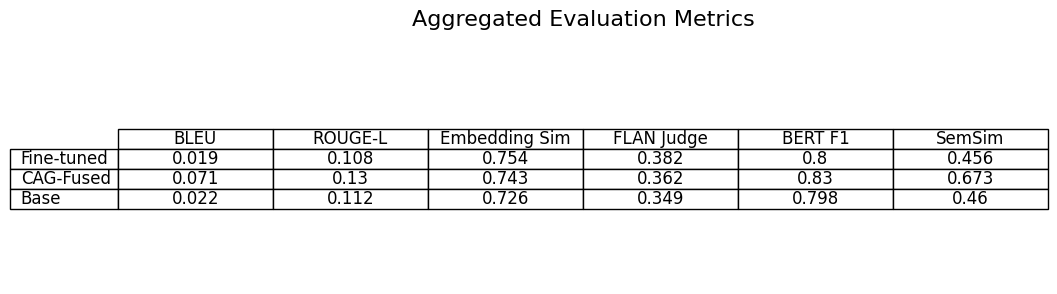

Aggregated Evaluation Metrics:
             BLEU  ROUGE-L  Embedding Sim  FLAN Judge  BERT F1  SemSim
Fine-tuned  0.019    0.108          0.754       0.382    0.800   0.456
CAG-Fused   0.071    0.130          0.743       0.362    0.830   0.673
Base        0.022    0.112          0.726       0.349    0.798   0.460


In [10]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nltk
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from bert_score import score as bert_score_func
from sentence_transformers import SentenceTransformer, util

# Download NLTK data if needed
nltk.download('punkt')

# ---------------------------- CONFIG ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FLAN_MODEL_NAME = "google/flan-t5-large"
STS_MODEL_NAME = "all-MiniLM-L6-v2"  # Sentence Transformer for semantic similarity

# ---------------------------- UPLOAD FILES ----------------------------
from google.colab import files
uploaded = files.upload()

def load_jsonl_file_from_upload(filename, uploaded_files):
    """
    Load a JSONL file from the uploaded dict or from local disk.
    """
    if filename in uploaded_files:
        file_bytes = uploaded_files[filename]
        text = file_bytes.decode('utf-8').splitlines()
        return [json.loads(line) for line in text if line.strip()]
    else:
        with open(filename, 'r') as f:
            return [json.loads(line) for line in f]

def load_all_data(uploaded_files):
    finetuned = load_jsonl_file_from_upload('Qwen2.5-3B-Instruct-bnb-4bit_finetuned_chomsky_responses.jsonl', uploaded_files)
    cagfused  = load_jsonl_file_from_upload('Qwen2.5-3B-Instruct-bnb-4bit_cagfused_output_responses.jsonl', uploaded_files)
    basemodel = load_jsonl_file_from_upload('Qwen2.5-3B-Instruct-bnb-4bit_basemodel_output_comparison.jsonl', uploaded_files)
    return finetuned, cagfused, basemodel

# ---------------------------- PREPROCESSING ----------------------------
def preprocess_response(response):
    """
    Remove system prompts and return only the assistant's answer.
    Searches for "assistant" (case-insensitive) and returns subsequent text.
    """
    if isinstance(response, str):
        pattern = r"(?i)assistant\s*[:\n]+\s*(.+)$"
        match = re.search(pattern, response, re.DOTALL)
        if match:
            return match.group(1).strip()
    return response

def extract_pairs(data):
    """
    Extract dialogue pairs from a JSONL file.

    For Fine-tuned: uses "expected_response" and "generated_response".
    For Base Model: uses "expected" and "base_response".
    For CAG-Fused: if "expected" exists, uses it; otherwise uses "prompt" as reference, and "response" as candidate.
    """
    pairs = []
    for item in data:
        if "expected_response" in item and "generated_response" in item:
            ref = item["expected_response"]
            cand = preprocess_response(item["generated_response"])
            pairs.append((ref, cand))
        elif "expected" in item and "base_response" in item:
            ref = item["expected"]
            cand = preprocess_response(item["base_response"])
            pairs.append((ref, cand))
        elif "response" in item:
            if "expected" in item:
                ref = item["expected"]
            elif "prompt" in item:
                ref = item["prompt"]
            else:
                ref = ""
            cand = preprocess_response(item["response"])
            pairs.append((ref, cand))
    return pairs

# ---------------------------- METRIC FUNCTIONS ----------------------------
def compute_bleu(reference, candidate):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], candidate.split(), smoothing_function=smoothie)

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    score = scorer.score(reference, candidate)
    return {
        'rouge1': score['rouge1'].fmeasure,
        'rouge2': score['rouge2'].fmeasure,
        'rougeL': score['rougeL'].fmeasure
    }

def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def compute_cosine_sim(ref, cand, tokenizer, model):
    emb1 = get_bert_embedding(ref, tokenizer, model)
    emb2 = get_bert_embedding(cand, tokenizer, model)
    return cosine_similarity(emb1, emb2)[0][0]

def compute_bert_f1(reference, candidate):
    P, R, F1 = bert_score_func([candidate], [reference], lang="en", verbose=False)
    return F1.mean().item()

def compute_semantic_similarity(reference, candidate, sts_model):
    """
    Compute semantic similarity using sentence embeddings from a Sentence Transformer.
    """
    emb_ref = sts_model.encode(reference, convert_to_tensor=True)
    emb_cand = sts_model.encode(candidate, convert_to_tensor=True)
    return util.cos_sim(emb_ref, emb_cand).item()

# ---------------------------- FLAN-T5 LARGE JUDGE ----------------------------
def load_flan_judge():
    flan_tokenizer = AutoTokenizer.from_pretrained(FLAN_MODEL_NAME)
    flan_model = AutoModelForSeq2SeqLM.from_pretrained(FLAN_MODEL_NAME).to(DEVICE)
    return flan_tokenizer, flan_model

def flan_judge_score(ref, cand, tokenizer, model):
    prompt = (
        f"On a scale of 1 to 10, how well does the following answer match the reference?\n\n"
        f"Reference: {ref}\n\nAnswer: {cand}\n\nScore (only a number):"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=3)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    try:
        score = float(re.findall(r"\d+\.?\d*", decoded)[0])
        return score / 10  # Normalize score to range 0–1
    except:
        return 0.0

# ---------------------------- MAIN EVALUATION ----------------------------
def evaluate(uploaded_files):
    # Load each file from the uploader.
    ft, cg, bm = load_all_data(uploaded_files)
    ft_pairs = extract_pairs(ft)
    cg_pairs = extract_pairs(cg)
    bm_pairs = extract_pairs(bm)

    print(f"Fine-tuned file pairs: {len(ft_pairs)}")
    print(f"CAG-Fused file pairs: {len(cg_pairs)}")
    print(f"Base Model file pairs: {len(bm_pairs)}")

    # Load a BERT model for computing cosine similarity (as Embedding Similarity).
    bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    bert_model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

    # Load Sentence Transformer for semantic similarity.
    sts_model = SentenceTransformer(STS_MODEL_NAME)

    # Load Flan-T5 for judgment.
    flan_tokenizer, flan_model = load_flan_judge()

    models = {
        "Fine-tuned": ft_pairs,
        "CAG-Fused": cg_pairs,
        "Base": bm_pairs
    }

    results = {name: {"BLEU": [], "ROUGE-L": [], "Embed": [], "FLAN": [], "BERT F1": [], "SemSim": []}
               for name in models}

    for name, pairs in models.items():
        for ref, cand in pairs:
            if not ref.strip():
                continue
            bleu = compute_bleu(ref, cand)
            rougeL = compute_rouge(ref, cand)['rougeL']
            embed = compute_cosine_sim(ref, cand, bert_tokenizer, bert_model)
            flan = flan_judge_score(ref, cand, flan_tokenizer, flan_model)
            bert_f1 = compute_bert_f1(ref, cand)
            sem_sim = compute_semantic_similarity(ref, cand, sts_model)
            results[name]["BLEU"].append(bleu)
            results[name]["ROUGE-L"].append(rougeL)
            results[name]["Embed"].append(embed)
            results[name]["FLAN"].append(flan)
            results[name]["BERT F1"].append(bert_f1)
            results[name]["SemSim"].append(sem_sim)

    # Aggregate metrics: compute the average for each metric per model.
    agg_results = {}
    for name in models:
        agg_results[name] = {
            "BLEU": np.mean(results[name]["BLEU"]) if results[name]["BLEU"] else 0.0,
            "ROUGE-L": np.mean(results[name]["ROUGE-L"]) if results[name]["ROUGE-L"] else 0.0,
            "Embedding Sim": np.mean(results[name]["Embed"]) if results[name]["Embed"] else 0.0,
            "FLAN Judge": np.mean(results[name]["FLAN"]) if results[name]["FLAN"] else 0.0,
            "BERT F1": np.mean(results[name]["BERT F1"]) if results[name]["BERT F1"] else 0.0,
            "SemSim": np.mean(results[name]["SemSim"]) if results[name]["SemSim"] else 0.0
        }

    df = pd.DataFrame(agg_results).T.round(3)

    # Create a table image using matplotlib's table functionality.
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    table = ax.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title("Aggregated Evaluation Metrics", fontsize=16, pad=20)
    plt.savefig("aggregated_metrics_table.png", bbox_inches='tight', dpi=300)
    plt.show()

    return df

# ---------------------------- RUN EVALUATION ----------------------------
results_df = evaluate(uploaded)
print("Aggregated Evaluation Metrics:")
print(results_df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving Qwen2.5-3B-Instruct-bnb-4bit_finetuned_chomsky_responses.jsonl to Qwen2.5-3B-Instruct-bnb-4bit_finetuned_chomsky_responses.jsonl
Saving Qwen2.5-3B-Instruct-bnb-4bit_cagfused_output_responses.jsonl to Qwen2.5-3B-Instruct-bnb-4bit_cagfused_output_responses.jsonl
Saving Qwen2.5-3B-Instruct-bnb-4bit_basemodel_output_comparison.jsonl to Qwen2.5-3B-Instruct-bnb-4bit_basemodel_output_comparison.jsonl
Fine-tuned file pairs: 100
CAG-Fused file pairs: 100
Base Model file pairs: 100


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

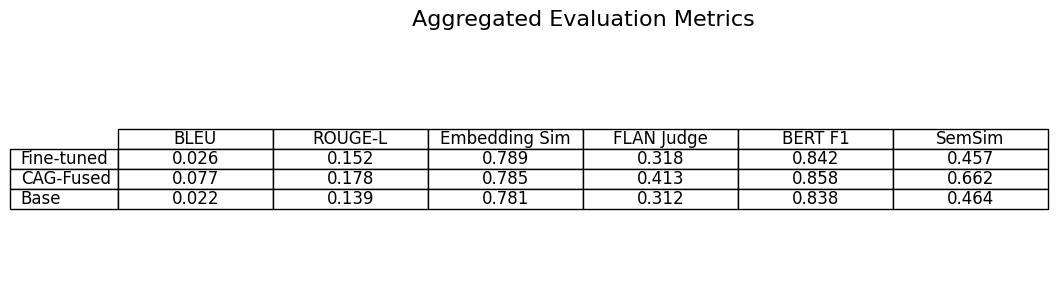

Aggregated Evaluation Metrics:
             BLEU  ROUGE-L  Embedding Sim  FLAN Judge  BERT F1  SemSim
Fine-tuned  0.026    0.152          0.789       0.318    0.842   0.457
CAG-Fused   0.077    0.178          0.785       0.413    0.858   0.662
Base        0.022    0.139          0.781       0.312    0.838   0.464


In [7]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nltk
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from bert_score import score as bert_score_func
from sentence_transformers import SentenceTransformer, util

# Download NLTK data if needed
nltk.download('punkt')

# ---------------------------- CONFIG ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FLAN_MODEL_NAME = "google/flan-t5-large"
STS_MODEL_NAME = "all-MiniLM-L6-v2"  # Sentence Transformer for semantic similarity

# ---------------------------- UPLOAD FILES ----------------------------
from google.colab import files
uploaded = files.upload()

def load_jsonl_file_from_upload(filename, uploaded_files):
    """
    Load a JSONL file from the uploaded dict or from local disk.
    """
    if filename in uploaded_files:
        file_bytes = uploaded_files[filename]
        text = file_bytes.decode('utf-8').splitlines()
        return [json.loads(line) for line in text if line.strip()]
    else:
        with open(filename, 'r') as f:
            return [json.loads(line) for line in f]

def load_all_data(uploaded_files):
    finetuned = load_jsonl_file_from_upload('llama_finetuned_chomsky_responses.jsonl', uploaded_files)
    cagfused  = load_jsonl_file_from_upload('llama_cagfused_output_responses.jsonl', uploaded_files)
    basemodel = load_jsonl_file_from_upload('llama_basemodel_output_comparison.jsonl', uploaded_files)
    return finetuned, cagfused, basemodel

# ---------------------------- PREPROCESSING ----------------------------
def preprocess_response(response):
    """
    Remove system prompts and return only the assistant's answer.
    Searches for "assistant" (case-insensitive) and returns subsequent text.
    """
    if isinstance(response, str):
        pattern = r"(?i)assistant\s*[:\n]+\s*(.+)$"
        match = re.search(pattern, response, re.DOTALL)
        if match:
            return match.group(1).strip()
    return response

def extract_pairs(data):
    """
    Extract dialogue pairs from a JSONL file.

    For Fine-tuned: uses "expected_response" and "generated_response".
    For Base Model: uses "expected" and "base_response".
    For CAG-Fused: if "expected" exists, uses it; otherwise uses "prompt" as reference, and "response" as candidate.
    """
    pairs = []
    for item in data:
        if "expected_response" in item and "generated_response" in item:
            ref = item["expected_response"]
            cand = preprocess_response(item["generated_response"])
            pairs.append((ref, cand))
        elif "expected" in item and "base_response" in item:
            ref = item["expected"]
            cand = preprocess_response(item["base_response"])
            pairs.append((ref, cand))
        elif "response" in item:
            if "expected" in item:
                ref = item["expected"]
            elif "prompt" in item:
                ref = item["prompt"]
            else:
                ref = ""
            cand = preprocess_response(item["response"])
            pairs.append((ref, cand))
    return pairs

# ---------------------------- METRIC FUNCTIONS ----------------------------
def compute_bleu(reference, candidate):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], candidate.split(), smoothing_function=smoothie)

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    score = scorer.score(reference, candidate)
    return {
        'rouge1': score['rouge1'].fmeasure,
        'rouge2': score['rouge2'].fmeasure,
        'rougeL': score['rougeL'].fmeasure
    }

def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def compute_cosine_sim(ref, cand, tokenizer, model):
    emb1 = get_bert_embedding(ref, tokenizer, model)
    emb2 = get_bert_embedding(cand, tokenizer, model)
    return cosine_similarity(emb1, emb2)[0][0]

def compute_bert_f1(reference, candidate):
    P, R, F1 = bert_score_func([candidate], [reference], lang="en", verbose=False)
    return F1.mean().item()

def compute_semantic_similarity(reference, candidate, sts_model):
    """
    Compute semantic similarity using sentence embeddings from a Sentence Transformer.
    """
    emb_ref = sts_model.encode(reference, convert_to_tensor=True)
    emb_cand = sts_model.encode(candidate, convert_to_tensor=True)
    return util.cos_sim(emb_ref, emb_cand).item()

# ---------------------------- FLAN-T5 LARGE JUDGE ----------------------------
def load_flan_judge():
    flan_tokenizer = AutoTokenizer.from_pretrained(FLAN_MODEL_NAME)
    flan_model = AutoModelForSeq2SeqLM.from_pretrained(FLAN_MODEL_NAME).to(DEVICE)
    return flan_tokenizer, flan_model

def flan_judge_score(ref, cand, tokenizer, model):
    prompt = (
        f"On a scale of 1 to 10, how well does the following answer match the reference?\n\n"
        f"Reference: {ref}\n\nAnswer: {cand}\n\nScore (only a number):"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=3)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    try:
        score = float(re.findall(r"\d+\.?\d*", decoded)[0])
        return score / 10  # Normalize score to range 0–1
    except:
        return 0.0

# ---------------------------- MAIN EVALUATION ----------------------------
def evaluate(uploaded_files):
    # Load each file from the uploader.
    ft, cg, bm = load_all_data(uploaded_files)
    ft_pairs = extract_pairs(ft)
    cg_pairs = extract_pairs(cg)
    bm_pairs = extract_pairs(bm)

    print(f"Fine-tuned file pairs: {len(ft_pairs)}")
    print(f"CAG-Fused file pairs: {len(cg_pairs)}")
    print(f"Base Model file pairs: {len(bm_pairs)}")

    # Load a BERT model for computing cosine similarity (as Embedding Similarity).
    bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    bert_model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

    # Load Sentence Transformer for semantic similarity.
    sts_model = SentenceTransformer(STS_MODEL_NAME)

    # Load Flan-T5 for judgment.
    flan_tokenizer, flan_model = load_flan_judge()

    models = {
        "Fine-tuned": ft_pairs,
        "CAG-Fused": cg_pairs,
        "Base": bm_pairs
    }

    results = {name: {"BLEU": [], "ROUGE-L": [], "Embed": [], "FLAN": [], "BERT F1": [], "SemSim": []}
               for name in models}

    for name, pairs in models.items():
        for ref, cand in pairs:
            if not ref.strip():
                continue
            bleu = compute_bleu(ref, cand)
            rougeL = compute_rouge(ref, cand)['rougeL']
            embed = compute_cosine_sim(ref, cand, bert_tokenizer, bert_model)
            flan = flan_judge_score(ref, cand, flan_tokenizer, flan_model)
            bert_f1 = compute_bert_f1(ref, cand)
            sem_sim = compute_semantic_similarity(ref, cand, sts_model)
            results[name]["BLEU"].append(bleu)
            results[name]["ROUGE-L"].append(rougeL)
            results[name]["Embed"].append(embed)
            results[name]["FLAN"].append(flan)
            results[name]["BERT F1"].append(bert_f1)
            results[name]["SemSim"].append(sem_sim)

    # Aggregate metrics: compute the average for each metric per model.
    agg_results = {}
    for name in models:
        agg_results[name] = {
            "BLEU": np.mean(results[name]["BLEU"]) if results[name]["BLEU"] else 0.0,
            "ROUGE-L": np.mean(results[name]["ROUGE-L"]) if results[name]["ROUGE-L"] else 0.0,
            "Embedding Sim": np.mean(results[name]["Embed"]) if results[name]["Embed"] else 0.0,
            "FLAN Judge": np.mean(results[name]["FLAN"]) if results[name]["FLAN"] else 0.0,
            "BERT F1": np.mean(results[name]["BERT F1"]) if results[name]["BERT F1"] else 0.0,
            "SemSim": np.mean(results[name]["SemSim"]) if results[name]["SemSim"] else 0.0
        }

    df = pd.DataFrame(agg_results).T.round(3)

    # Create a table image using matplotlib's table functionality.
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    table = ax.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title("Aggregated Evaluation Metrics", fontsize=16, pad=20)
    plt.savefig("aggregated_metrics_table.png", bbox_inches='tight', dpi=300)
    plt.show()

    return df

# ---------------------------- RUN EVALUATION ----------------------------
results_df = evaluate(uploaded)
print("Aggregated Evaluation Metrics:")
print(results_df)
